## Check observables given a results file from a `TRSL` simulation

We are checking:
1. Protein production rate
2. Ribosome speed
3. Ribosome density (TODO: compare with Siwiak)
4. Number of free ribosomes

In [1]:
import cPickle as pkl
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

Function to replace `_numpypy.multiarray` by `numpy.core.multiarray`. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [2]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

The following pickle file contains the simulation results:

In [3]:
filepath = "../results/full transcriptome and exome, no decay, specific best estimate initiation rates according to Plotkin_20150818_1920_3599s.p"

Make file readable by `ipython` in case it was created by `pypy`:

In [4]:
replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")

In [5]:
results = pkl.load(open(filepath))

### 1. Protein production rate

In [6]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein']
for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

Plot some randomly selected timecourses:

In [7]:
size = 4
protnames_plot = np.array(random.sample(protnames, size*size))
protnames_plot.shape = (size, size)

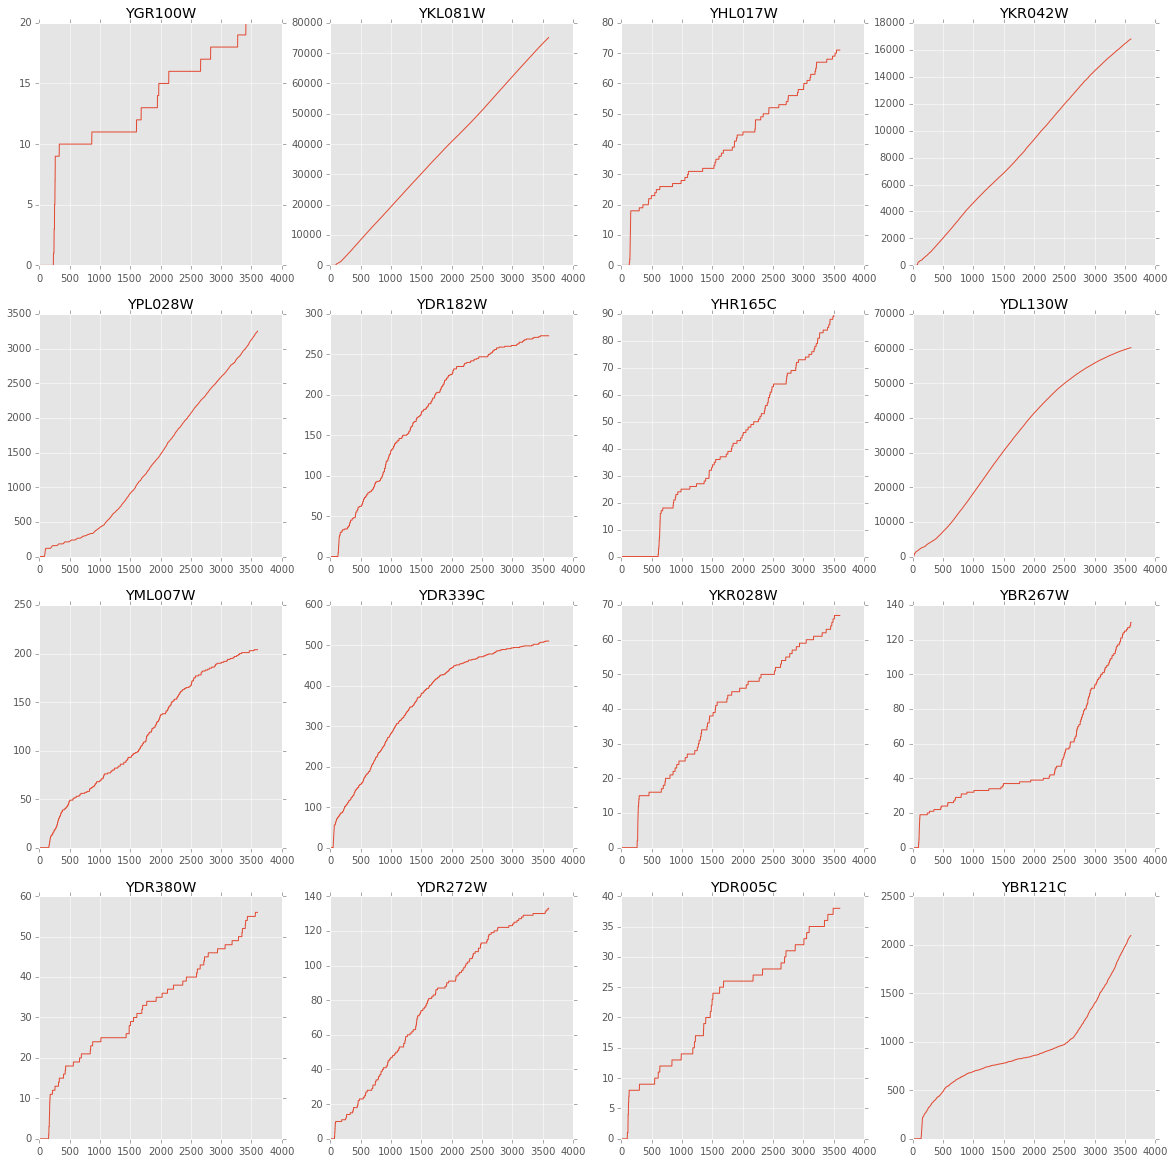

In [8]:
fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        ax[i, j].plot(results['timerange'], results['timecourses'][protnames_plot[i][j]])
        ax[i, j].set_title(protnames_plot[i][j])

For each protein, calculate speed of translation (TODO: start and stop should be automatic):

In [9]:
start, stop = 599, 3599  # to exclude the "burn in" phase
prot_speeds = {}

for prot in protnames:
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * stop - start)
    if prot_speeds[prot] > 50: 
        print prot, prot_speeds[prot]

YKL060C 78.9
YAL038W 113.273333333
YCR012W 62.2076666667
YOL086C 50.837
YLR044C 255.591666667
YOL040C 52.4876666667


In [10]:
pd.Series(prot_speeds.values()).describe()

count    2496.000000
mean        1.035836
std         6.943294
min         0.000667
25%         0.024667
50%         0.070000
75%         0.243000
max       255.591667
dtype: float64

Distribution of translation speeds (finished protein molecules per second):

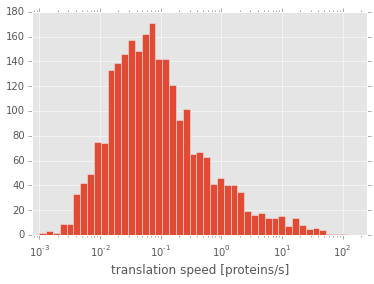

In [14]:
plt.hist(prot_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                              np.log10(max(prot_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
plt.gca().set_xlabel('translation speed [proteins/s]')
plt.show()

In [15]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

5917

In [16]:
peptide_speeds = {prot: prot_speeds[prot] * len(orf_genomic_dict[prot]) / 3.0 for prot in prot_speeds}

In [17]:
pd.Series(peptide_speeds.values()).describe()

count      2496.000000
mean        377.096605
std        3414.163554
min           0.340000
25%           9.370333
50%          25.617833
75%          87.378250
max      144153.700000
dtype: float64

Distribution of speeds of peptide bond creation (peptide bonds per second):

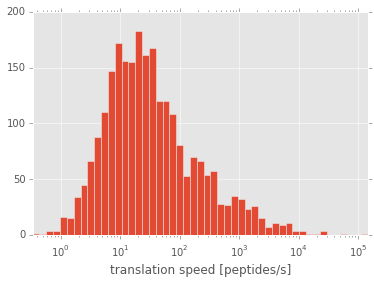

In [18]:
plt.hist(peptide_speeds.values(), bins = 10**np.linspace(np.log10(min(peptide_speeds.values())+0.0001), 
                                                              np.log10(max(peptide_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(peptide_speeds.values())+0.0001, max(peptide_speeds.values())])
plt.gca().set_xlabel('translation speed [peptides/s]')
plt.show()

Scatter plot speed, initiation rate and transcript abundance:

In [19]:
init_rates_plotkin = pkl.load(open('../parameters/init_rates_plotkin.p'))
print len(init_rates_plotkin)

2569


In [20]:
transcriptome_plotkin = pkl.load(open('../parameters/transcriptome_plotkin.p'))
print len(transcriptome_plotkin)
print sum(transcriptome_plotkin.values())

4839
60000


In [21]:
df1 = pd.DataFrame.from_dict(peptide_speeds.items())
df1.columns = ['name', 'peptide_speeds']

df2 = pd.DataFrame.from_dict(init_rates_plotkin.items())
df2.columns = ['name', 'init_rates_plotkin']

df3 = pd.DataFrame.from_dict(transcriptome_plotkin.items())
df3.columns = ['name', 'transcriptome_plotkin']

In [22]:
df = pd.merge(df1, df2, left_on='name', right_on='name', how='outer')
df = pd.merge(df, df3, left_on='name', right_on='name', how='outer')

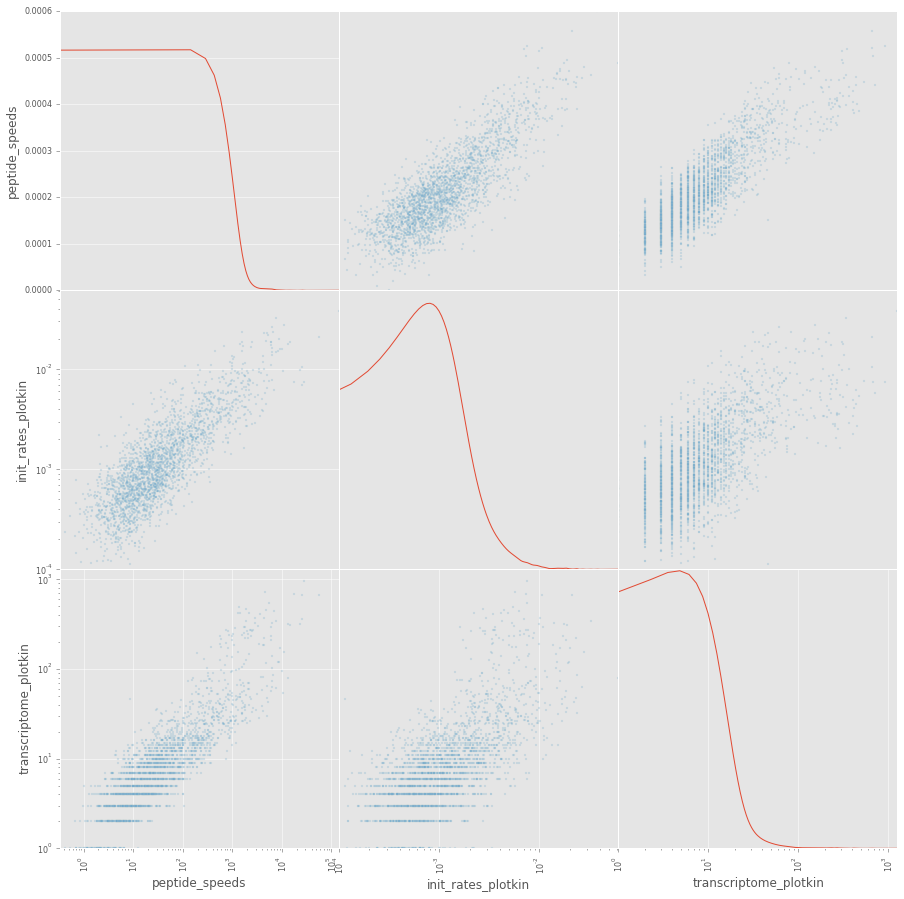

In [23]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0001, df[df.columns[i+1]].min())
        minj = max(0.0001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')         

Best predictor of peptide translation speed appears to be initiation rate but also transcript abundance has some effect.

### 2. Ribosome speed

We read a results dictionary which contains tic/toc results for the mRNAs:

In [24]:
filepath = "../results/20000 transcriptome, full exome, no decay, Plotkin initiation probabilities_20150825_1823_3599s.p"

Function to replace `_numpypy.multiarray` by `numpy.core.multiarray`. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [25]:
replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")
results = pkl.load(open(filepath))

The following is smaller than 20000 (or 19969 as in the original file), probably because not for every gene in `transcriptome_plotkin_20000.p` there is an initiation rate available.

In [26]:
len(results['transcriptome'])

16724

In [27]:
transcript_tic_toc = {transcript.index: transcript.tic_toc for transcript in results['transcriptome']}

In [28]:
transcript_tic_toc_averages = {index: np.mean([toc-tic for (tic, toc) in transcript_tic_toc[index]]) for index in transcript_tic_toc}

In [29]:
transcript_df = pd.DataFrame(transcript_tic_toc_averages.values(), index=transcript_tic_toc_averages.keys())

In [30]:
transcript_df = pd.DataFrame(pd.Series(transcript_tic_toc_averages))
transcript_df.columns = ['tic_toc']

In [31]:
temp_df = pd.DataFrame(pd.Series({transcript.index: transcript.geneID for transcript in results['transcriptome']}))
temp_df.columns = ['geneID']

In [32]:
transcript_df = pd.merge(transcript_df, temp_df, left_index=True, right_index=True, how='outer')

In [33]:
gene_tic_toc = transcript_df.groupby('geneID').mean().to_dict()['tic_toc']
gene_tic_toc_df = pd.DataFrame.from_dict(gene_tic_toc.items())
gene_tic_toc_df.columns = ['name', 'tic_toc']

In [34]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

5917

In [35]:
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

In [36]:
pd.Series(orf_lengths.values()).describe()

count     5917.000000
mean      1485.306236
std       1149.149051
min         51.000000
25%        711.000000
50%       1218.000000
75%       1887.000000
max      14733.000000
dtype: float64

In [37]:
df1 = pd.DataFrame.from_dict(orf_lengths.items())
df1.columns = ['name', 'orf_length']

In [38]:
df = pd.merge(gene_tic_toc_df, df1, left_on='name', right_on='name', how='outer')

Scatter plot of ORF lengths against ribosome runtimes:

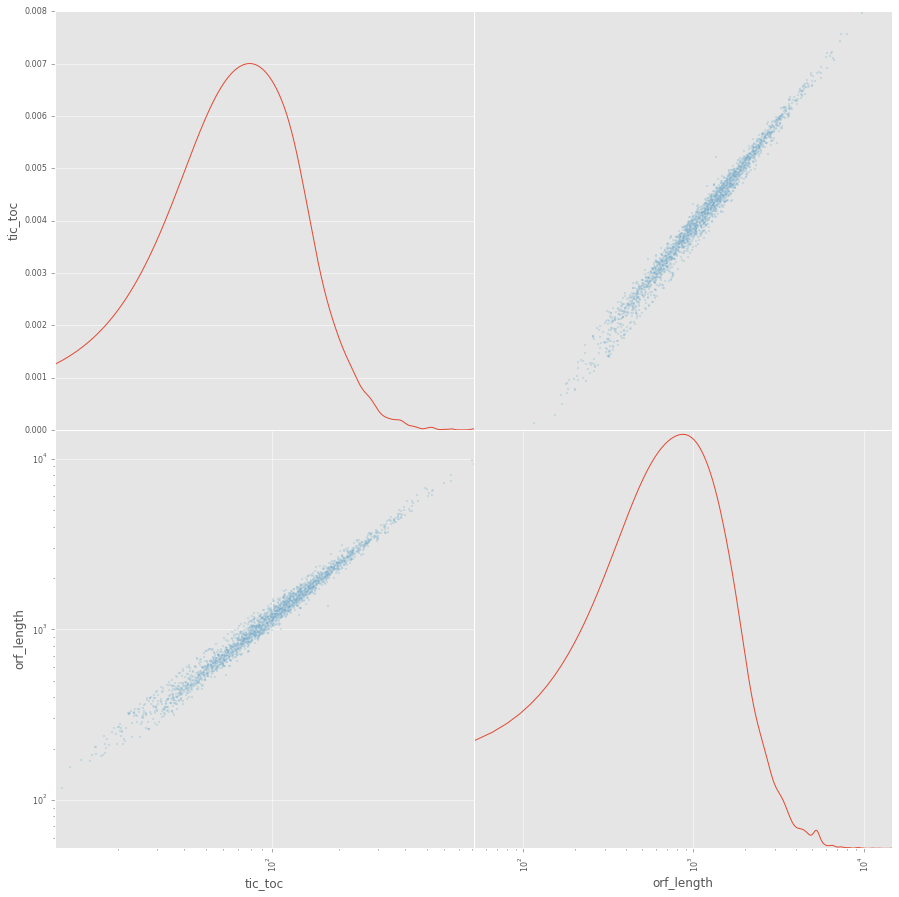

In [39]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0001, df[df.columns[i+1]].min())
        minj = max(0.0001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj+1, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini+1, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')            

In [46]:
ribo_inverse_speed_dict = {geneID: gene_tic_toc[geneID]/orf_lengths[geneID] for geneID in gene_tic_toc}

In [47]:
pd.Series(ribo_inverse_speed_dict.values()).describe()

count    2415.000000
mean        0.084858
std         0.007183
min         0.065803
25%         0.080472
50%         0.084706
75%         0.088999
max         0.131732
dtype: float64

Distribution of inverse ribosome speeds (seconds per nucleotide):

(array([   5.,   11.,   12.,   21.,   17.,   25.,   24.,   43.,   30.,
          48.,   51.,   65.,   84.,   93.,  119.,  133.,  153.,  153.,
         138.,  145.,  137.,  163.,  118.,   86.,   97.,   69.,   69.,
          70.,   50.,   40.,   29.,   23.,   18.,   14.,   17.,    6.,
           4.,    3.,    9.,    6.,    2.,    5.,    4.,    3.,    0.,
           0.,    0.,    1.,    1.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([ 0.06580341,  0.06680341,  0.06780341,  0.06880341,  0.06980341,
         0.07080341,  0.07180341,  0.07280341,  0.07380341,  0.07480341,
         0.07580341,  0.07680341,  0.07780341,  0.07880341,  0.07980341,
         0.08080341,  0.08180341,  0.08280341,  0.08380341,  0.08480341,
         0.08580341,  0.08680341,  0.08780341,  0.08880341,  0.08980341,
         0.09080341,  0.09180341,  0.09280341,  0.09380341,  0.09480341,
         0.09580341,  0.09680341,  0.0978

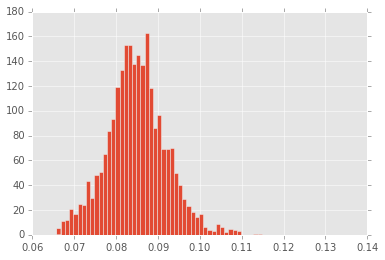

In [51]:
plt.hist(ribo_inverse_speed_dict.values(), bins=np.arange(min(ribo_inverse_speed_dict.values()), max(ribo_inverse_speed_dict.values()), 0.001))


In [49]:
ribo_speed_dict = {geneID: orf_lengths[geneID]/3.0/gene_tic_toc[geneID] for geneID in gene_tic_toc}

Translation speed distribution (codons per second):

(array([   1.,    0.,    0.,    1.,    1.,   12.,   19.,   19.,   53.,
          97.,  172.,  201.,  291.,  323.,  303.,  288.,  200.,  137.,
          92.,   56.,   57.,   34.,   27.,   18.,   11.]),
 array([ 2.53039455,  2.63039455,  2.73039455,  2.83039455,  2.93039455,
         3.03039455,  3.13039455,  3.23039455,  3.33039455,  3.43039455,
         3.53039455,  3.63039455,  3.73039455,  3.83039455,  3.93039455,
         4.03039455,  4.13039455,  4.23039455,  4.33039455,  4.43039455,
         4.53039455,  4.63039455,  4.73039455,  4.83039455,  4.93039455,
         5.03039455]),
 <a list of 25 Patch objects>)

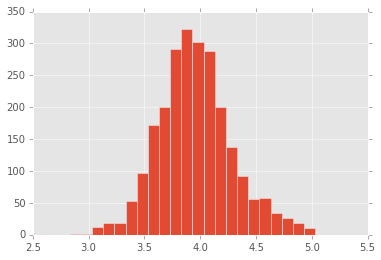

In [54]:
plt.hist(ribo_speed_dict.values(), bins=np.arange(min(ribo_speed_dict.values()), max(ribo_speed_dict.values()), 0.1))

TODO: Check against CAI

### 3. Ribosome density

Definition of ribosome density: average number of ribosomes per codon
Can depend on:

a) time - zero at first, reaches steady state (not discussed further)

b) position - density might be high at 5' end if initation rate is higher than rate at which ribosomes are transported away from initiation site

In [62]:
import shelve

filepath = "../results/ribosome_timecourses_20150916_1315.db"

d = shelve.open(filepath)

In [71]:
resultsfile = "../results/20000 transcriptome, full exome, no decay, Plotkin initiation probabilities_20150916_1321_0089s.p"

In [72]:
replace(resultsfile, "_numpypy.multiarray", "numpy.core.multiarray")
results = pkl.load(open(resultsfile))

In [95]:
for mRNA in results['transcriptome']:
    print mRNA.index
    print mRNA.geneID
    n_codons = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]
    ribos = []
    
    #print d['mRNA_'+str(mRNA.index).zfill(5)][-1]

0
YBR177C
452.0
1
YBR177C
452.0
2
YBR177C
452.0
3
YIL140W
824.0
4
YIL140W
824.0
5
YLR268W
215.0
6
YLR268W
215.0
7
YLR268W
215.0
8
YIR004W
433.0
9
YAL008W
199.0
10
YOR043W
487.0
11
YOR043W
487.0
12
YOR043W
487.0
13
YJL122W
176.0
14
YJL122W
176.0
15
YJL122W
176.0
16
YJL122W
176.0
17
YNL300W
103.0
18
YNL300W
103.0
19
YNL300W
103.0
20
YLR244C
388.0
21
YLR244C
388.0
22
YLR244C
388.0
23
YLR244C
388.0
24
YLR244C
388.0
25
YLR244C
388.0
26
YPL144W
149.0
27
YPL144W
149.0
28
YJR084W
424.0
29
YBR135W
151.0
30
YBR135W
151.0
31
YBR004C
434.0
32
YBR160W
299.0
33
YHR007C
531.0
34
YHR007C
531.0
35
YHR007C
531.0
36
YHR007C
531.0
37
YHR007C
531.0
38
YHR007C
531.0
39
YHR007C
531.0
40
YHR007C
531.0
41
YHR007C
531.0
42
YHR007C
531.0
43
YHR007C
531.0
44
YHR007C
531.0
45
YHR007C
531.0
46
YHR007C
531.0
47
YHR007C
531.0
48
YLR197W
505.0
49
YLR197W
505.0
50
YLR197W
505.0
51
YLR197W
505.0
52
YLR197W
505.0
53
YLR197W
505.0
54
YLR197W
505.0
55
YLR197W
505.0
56
YLR197W
505.0
57
YLR197W
505.0
58
YLR197W
505.0
59
YLR1

In [98]:
last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]
# TODO: convert to 0/1 array, add to gene counter

In [68]:
d.keys()[0], d[d.keys()[0]][-1]

('mRNA_10900',
 {123: None,
  315: None,
  549: None,
  582: None,
  612: None,
  642: None,
  675: None,
  705: 7,
  735: None,
  801: None,
  834: None,
  900: None,
  966: None,
  1026: None,
  1098: None})

In [73]:
results.keys()

['n_tRNA',
 'description',
 'n_ribosomes',
 'timerange',
 'proteome',
 'transcriptome',
 'duration',
 'time_stamp',
 'timecourses']

In [77]:
results['transcriptome'][0].geneID

'YBR177C'

In [81]:
max(orf_lengths.values())/3.0

4911.0

In [84]:
results['proteome']

Counter({'YLR110C': 3679, 'YKL152C': 3434, 'YJL189W': 2870, 'YOL127W': 2723, 'YGL103W': 2676, 'YOL040C': 2516, 'YOR369C': 2494, 'YBL092W': 2244, 'YJR123W': 2191, 'YDR050C': 2085, 'YLR075W': 2075, 'YPR043W': 2025, 'YGR027C': 1996, 'YDR382W': 1958, 'YDR064W': 1925, 'YLR109W': 1909, 'YKL060C': 1865, 'YHL015W': 1792, 'YOL039W': 1753, 'YLR325C': 1751, 'YDL075W': 1703, 'YKL056C': 1701, 'YNL178W': 1686, 'YLR185W': 1670, 'YNL069C': 1657, 'YLR061W': 1622, 'YAL003W': 1596, 'YOR293W': 1591, 'YEL034W': 1582, 'YDL130W': 1573, 'YBR189W': 1552, 'YDL081C': 1538, 'YJL190C': 1490, 'YHR010W': 1457, 'YGR034W': 1445, 'YJL136C': 1410, 'YOL086C': 1409, 'YPL143W': 1313, 'YOL109W': 1253, 'YHR021C': 1251, 'YGL030W': 1244, 'YOR096W': 1243, 'YGL123W': 1240, 'YDR155C': 1217, 'YKL180W': 1197, 'YML063W': 1147, 'YPL131W': 1141, 'YDR500C': 1124, 'YLR388W': 1121, 'YML073C': 1095, 'YML028W': 988, 'YLR340W': 979, 'YMR116C': 855, 'YER131W': 812, 'YLR333C': 807, 'YIL133C': 796, 'YOR167C': 779, 'YLR150W': 735, 'YLR441C': 71